In [102]:
!pip install dagshub

In [103]:
from dagshub import get_repo_bucket_client

s3 = get_repo_bucket_client("Omdena/IREX-El-Salvador-Sentiment")

Client created. Use the name of the repo (IREX-El-Salvador-Sentiment) as the name of the bucket

In [104]:
import torch

In [105]:
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [106]:
import warnings
warnings.filterwarnings('ignore')

In [107]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
import re
from typing import Union, List

class CleanText():
    """ clearing text except digits () . , word character """

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text

def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text

clean = CleanText()

In [109]:
clean

In [110]:
# label encode
def label_encode(x):
    if x == 'POS':
        return 0
    if x == 'NEU':
        return 1
    if x == 'NEG':
        return 2

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
import pandas as pd
df = pd.read_csv('/content/sentiment_beto_withlabels.csv')
df.head()

,Post Type,Profile Name,Date,Time,Likes,Text,AP,AP + JA Revised,sentiment_output,sentiment_probability,English Text (Google Translate),Match
0,Astronaut Post,Elizabeth Menjivar,2024-04-13,03:29:29,43,Dios lo bendiga por ser un gran ser humano,POS,POS,POS,0.997756,God bless him for being a great human being.,True
1,Astronaut Post,Mila Mijango,2024-04-17,17:29:01,6,"Me encanta la humanidad de nuestro astronauta,...",POS,POS,POS,0.998780,"I love the humanity of our astronaut, a man wi...",True
2,Astronaut Post,Any Rodríguez,2024-04-13,04:00:29,18,Dos grandes hombres haciendo historia. Gracias...,POS,POS,POS,0.998589,Two great men making history. Thank you for al...,True
3,Astronaut Post,Sara Cespedes,2024-04-13,08:22:47,136,Nayib y Frank dos grandes ejemplo de umildad y...,POS,POS,POS,0.998770,"Nayib and Frank, two great examples of humilit...",True
4,Astronaut Post,Martha Morales,2024-04-13,03:13:56,70,A Colombia le falta un precidente con este ...,NEU,POS,POS,0.984938,"Colombia lacks a precedent with this one, I am...",False


In [113]:
df.columns

Index(['Post Type', 'Profile Name', 'Date', 'Time', 'Likes', 'Text', 'AP',
       'AP + JA Revised', 'sentiment_output', 'sentiment_probability',
       'English Text (Google Translate)', 'Match'],
      dtype='object')

In [114]:
# count of ratings
fig = px.histogram(df,
             x = 'AP',
             title = 'Histogram of Review Rating',
             template = 'ggplot2',
             color = 'AP',
             color_discrete_sequence= px.colors.sequential.Blues_r,
             opacity = 0.8,
             height = 525,
             width = 835,
            )

fig.update_yaxes(title='Count')
fig.show()

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Post Type                        333 non-null    object 
 1   Profile Name                     333 non-null    object 
 2   Date                             333 non-null    object 
 3   Time                             333 non-null    object 
 4   Likes                            333 non-null    int64  
 5   Text                             333 non-null    object 
 6   AP                               333 non-null    object 
 7   AP + JA Revised                  329 non-null    object 
 8   sentiment_output                 333 non-null    object 
 9   sentiment_probability            333 non-null    float64
 10  English Text (Google Translate)  333 non-null    object 
 11  Match                            333 non-null    bool   
dtypes: bool(1), float64(1)

In [116]:
# Summary statistics for numerical columns
print(df.describe())

            Likes  sentiment_probability
count  333.000000             333.000000
mean     6.435435               0.960229
std     13.511693               0.092082
min      0.000000               0.520591
25%      0.000000               0.980445
50%      2.000000               0.997350
75%      6.000000               0.998504
max    136.000000               0.999315


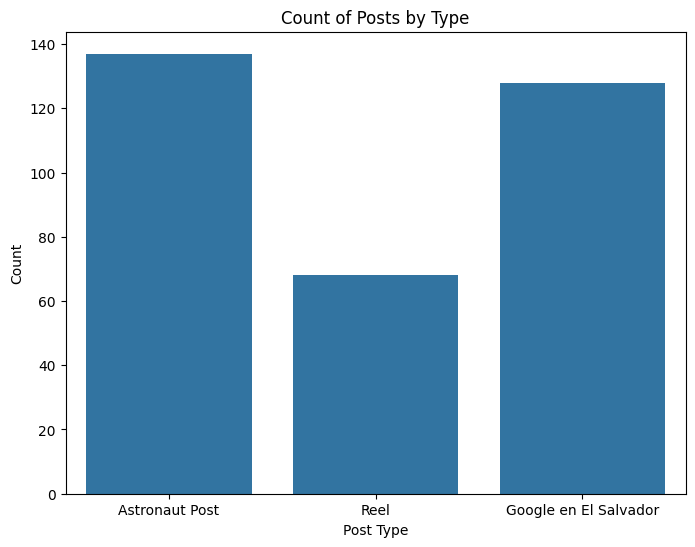

In [117]:
# Count plot for 'Post Type'
plt.figure(figsize=(8, 6))
sns.countplot(x='Post Type', data=df)
plt.title('Count of Posts by Type')
plt.xlabel('Post Type')
plt.ylabel('Count')
plt.show()

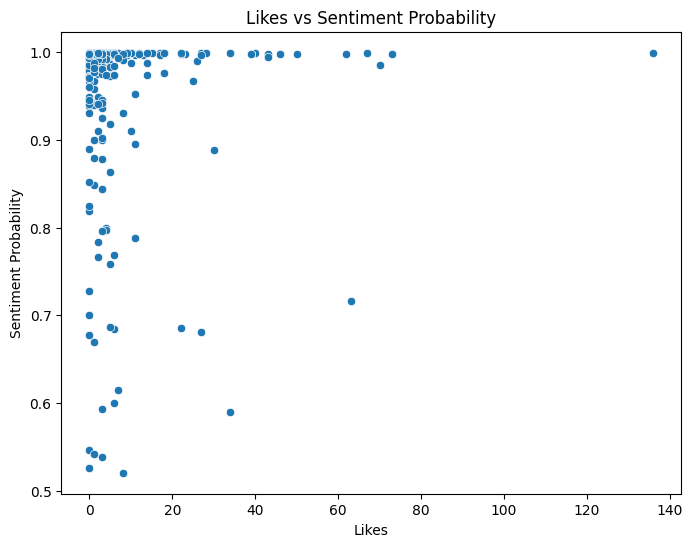

In [118]:
# Scatter plot for 'Likes' vs 'sentiment_probability'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Likes', y='sentiment_probability', data=df)
plt.title('Likes vs Sentiment Probability')
plt.xlabel('Likes')
plt.ylabel('Sentiment Probability')
plt.show()

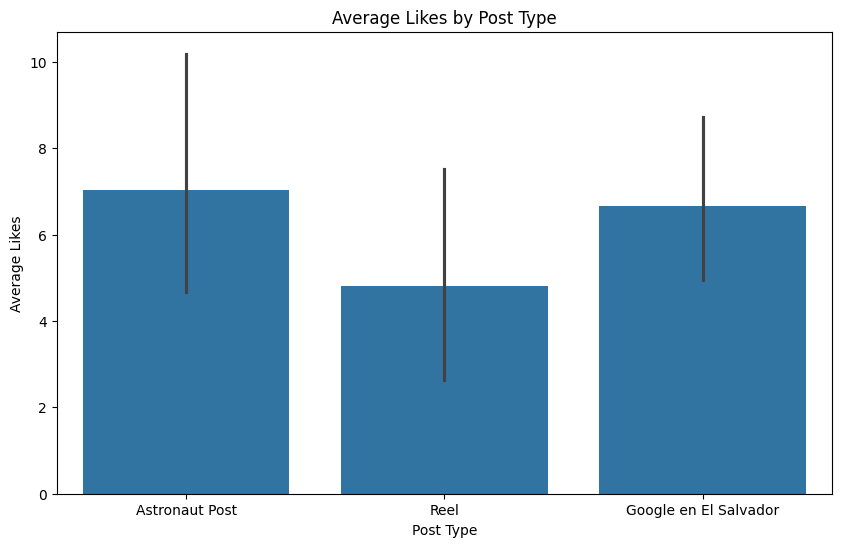

In [119]:
# Bar plot for average 'Likes' by 'Post Type'
plt.figure(figsize=(10, 6))
sns.barplot(x='Post Type', y='Likes', data=df)
plt.title('Average Likes by Post Type')
plt.xlabel('Post Type')
plt.ylabel('Average Likes')
plt.show()

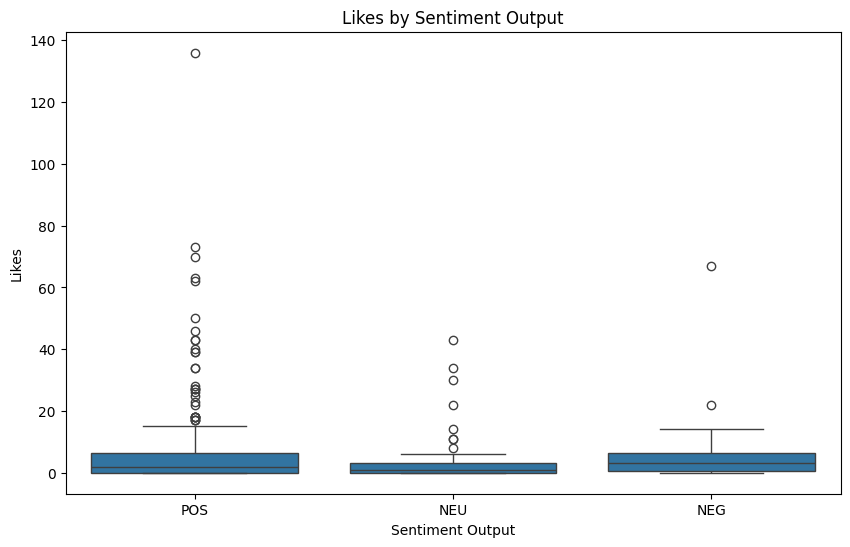

In [120]:
# Box plot for 'Likes' by 'sentiment_output'
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_output', y='Likes', data=df)
plt.title('Likes by Sentiment Output')
plt.xlabel('Sentiment Output')
plt.ylabel('Likes')
plt.show()

In [121]:
# clean text, lowercase and remove punk
df["Text_Clean"] = df["Text"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))
df["label"] = df["AP"].apply(lambda x: label_encode(x))


In [122]:

df.head()

,Post Type,Profile Name,Date,Time,Likes,Text,AP,AP + JA Revised,sentiment_output,sentiment_probability,English Text (Google Translate),Match,Text_Clean,label
0,Astronaut Post,Elizabeth Menjivar,2024-04-13,03:29:29,43,Dios lo bendiga por ser un gran ser humano,POS,POS,POS,0.997756,God bless him for being a great human being.,True,dios lo bendiga por ser un gran ser humano,0
1,Astronaut Post,Mila Mijango,2024-04-17,17:29:01,6,"Me encanta la humanidad de nuestro astronauta,...",POS,POS,POS,0.998780,"I love the humanity of our astronaut, a man wi...",True,me encanta la humanidad de nuestro astronauta ...,0
2,Astronaut Post,Any Rodríguez,2024-04-13,04:00:29,18,Dos grandes hombres haciendo historia. Gracias...,POS,POS,POS,0.998589,Two great men making history. Thank you for al...,True,dos grandes hombres haciendo historia gracias...,0
3,Astronaut Post,Sara Cespedes,2024-04-13,08:22:47,136,Nayib y Frank dos grandes ejemplo de umildad y...,POS,POS,POS,0.998770,"Nayib and Frank, two great examples of humilit...",True,nayib y frank dos grandes ejemplo de umildad y...,0
4,Astronaut Post,Martha Morales,2024-04-13,03:13:56,70,A Colombia le falta un precidente con este ...,NEU,POS,POS,0.984938,"Colombia lacks a precedent with this one, I am...",False,a colombia le falta un precidente con este ...,1


In [123]:
for i in df.columns:
  print(i, df[i].value_counts())

Post Type Post Type
Astronaut Post           137
Google en El Salvador    128
Reel                      68
Name: count, dtype: int64
Profile Name Profile Name
Thelma Trejo                    13
Alejandra Rugerio                3
Liliana Serrano                  2
Alba Beltran                     2
Eliz ぁ                           2
                                ..
Elizabeth Quijada                1
Nelson Rivas Baires              1
Blanca N Magaña Araujo           1
Gladis Gonzalez de Hernandez     1
Noemí Cabarcas                   1
Name: count, Length: 305, dtype: int64
Date Date
2024-04-18    167
2024-04-13    114
2024-04-19     20
2024-04-14     11
2024-04-20      7
2024-04-17      4
2024-04-15      4
2024-04-16      3
2024-04-21      3
Name: count, dtype: int64
Time Time
02:04:24    2
03:04:26    2
02:08:46    2
02:21:20    2
02:19:47    1
           ..
14:03:43    1
23:26:45    1
04:32:05    1
16:10:21    1
05:23:21    1
Name: count, Length: 329, dtype: int64
Likes Likes
0   

In [124]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40,
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

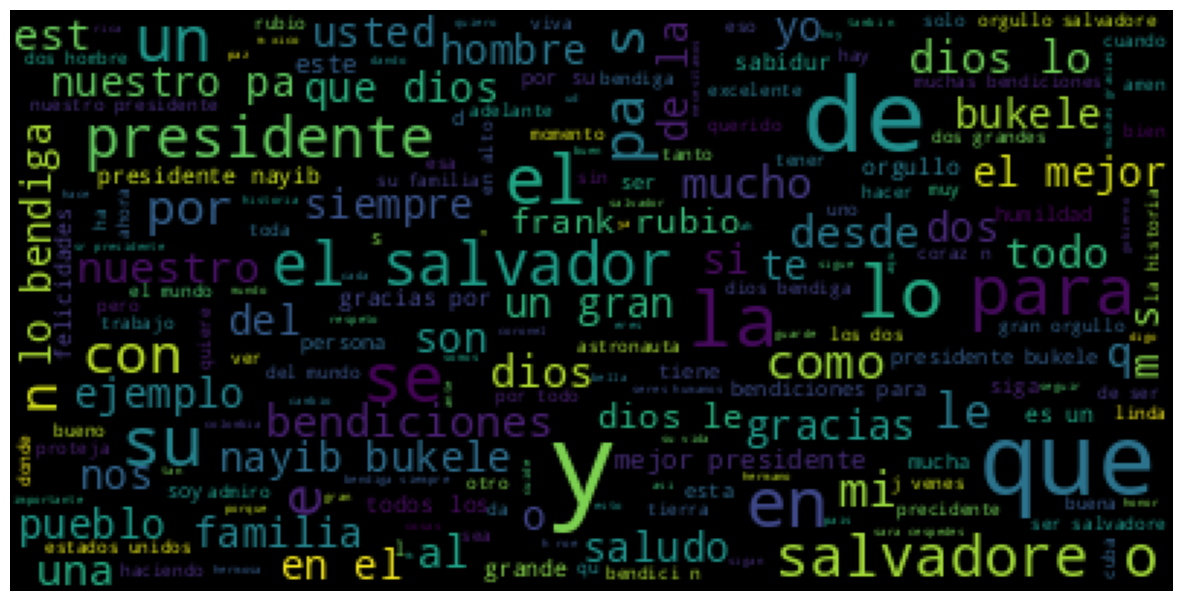

In [125]:
show_wordcloud(df["Text_Clean"].values)

In [126]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig.add_trace(go.Pie(labels=df.AP.value_counts().index,
                             values=df.label.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=df.AP.value_counts().index, y=df.label.value_counts().values, marker_color = colors), 1,2)

fig.show()

In [127]:
# tokenize data
df["tokenized_review"] = df.Text.apply(lambda x: tokenize(x))
# calculate token count for any sent
df["sent_token_length"] = df["tokenized_review"].apply(lambda x: len(x.split()))

In [128]:
df["sent_token_length"] = df["tokenized_review"].apply(lambda x: len(x.split()))
fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [129]:

(df.sent_token_length < 128).mean()

0.9819819819819819

In [130]:
df.sent_token_length

0       9
1      53
2      15
3      27
4      15
       ..
328    20
329    13
330    14
331    35
332    17
Name: sent_token_length, Length: 333, dtype: int64

In [131]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [132]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch


In [133]:
"""# Tokenizing the text data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
"""

"# Tokenizing the text data using BERT tokenizer\ntokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)\n"

In [134]:
"""# Function to encode the texts using BERT tokenizer
def encode_texts(texts, max_length=128):
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )"""

"# Function to encode the texts using BERT tokenizer\ndef encode_texts(texts, max_length=128):\n    return tokenizer.batch_encode_plus(\n        texts,\n        add_special_tokens=True,\n        max_length=max_length,\n        pad_to_max_length=True,\n        return_attention_mask=True,\n        return_tensors='pt'\n    )"

In [135]:
"""# Encoding the texts
encoded_texts = encode_texts(df['Text_Clean'].tolist())"""

"# Encoding the texts\nencoded_texts = encode_texts(df['Text_Clean'].tolist())"

In [137]:
# data tokenize with bert tokenizer
df["sent_bert_token_length"] = df["Text"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

In [138]:
fig = px.histogram(df, x="sent_bert_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [139]:
(df.sent_bert_token_length < 128).mean()

0.960960960960961

In [140]:
# valvulate char count for each review
df['char_count'] = df['Text_Clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))


    plt.suptitle(f'{title}', fontsize=24)

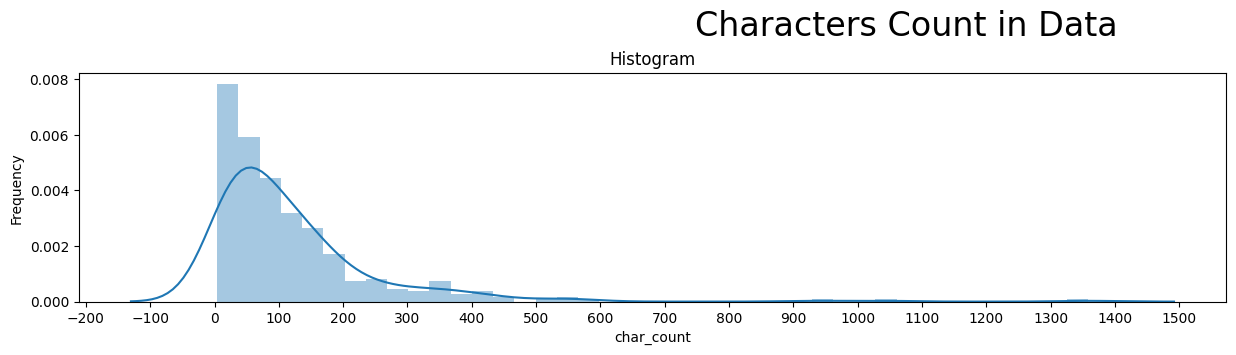

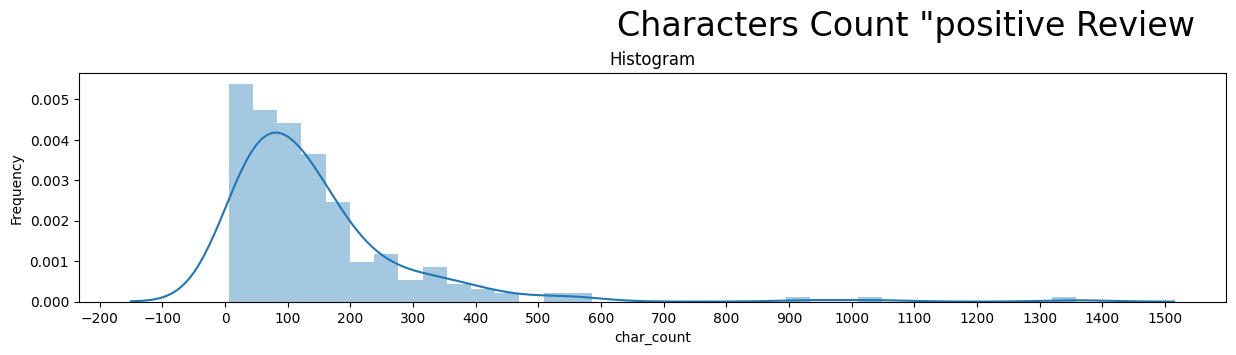

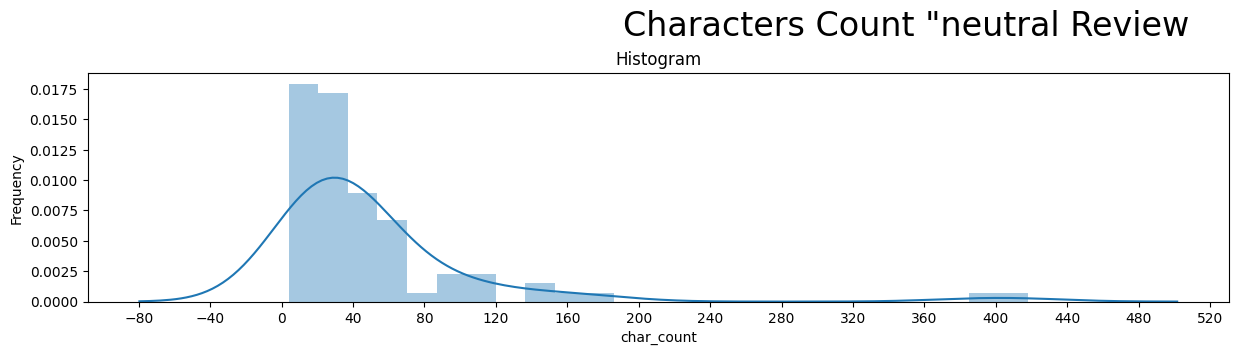

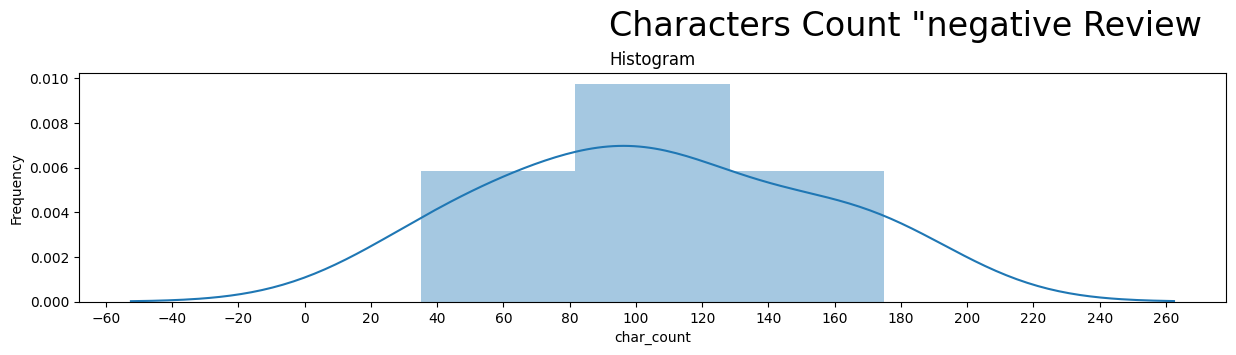

In [141]:
plot_dist3(df, 'char_count',
           'Characters Count in Data')
plot_dist3(df[df['label'] == 0], 'char_count',
           'Characters Count "positive Review')
plot_dist3(df[df['label'] == 1], 'char_count',
           'Characters Count "neutral Review')
plot_dist3(df[df['label'] == 2], 'char_count',
           'Characters Count "negative Review')

In [142]:
# Define the bins for character counts
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000]

# Create a new column to store the bin labels
df['char_count_bin'] = pd.cut(df['char_count'], bins=bins)

# Group by the character count bins and calculate the count in each bin
char_count_distribution = df.groupby('char_count_bin').size().reset_index(name='count')

print(char_count_distribution)

   char_count_bin  count
0         (0, 50]    120
1       (50, 100]     75
2      (100, 150]     54
3      (150, 200]     34
4      (200, 250]     14
5      (250, 300]      8
6      (300, 350]     10
7      (350, 400]      5
8      (400, 450]      5
9      (450, 500]      1
10    (500, 1000]      5


In [143]:
def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    plt.suptitle(f'{title}', fontsize=24)

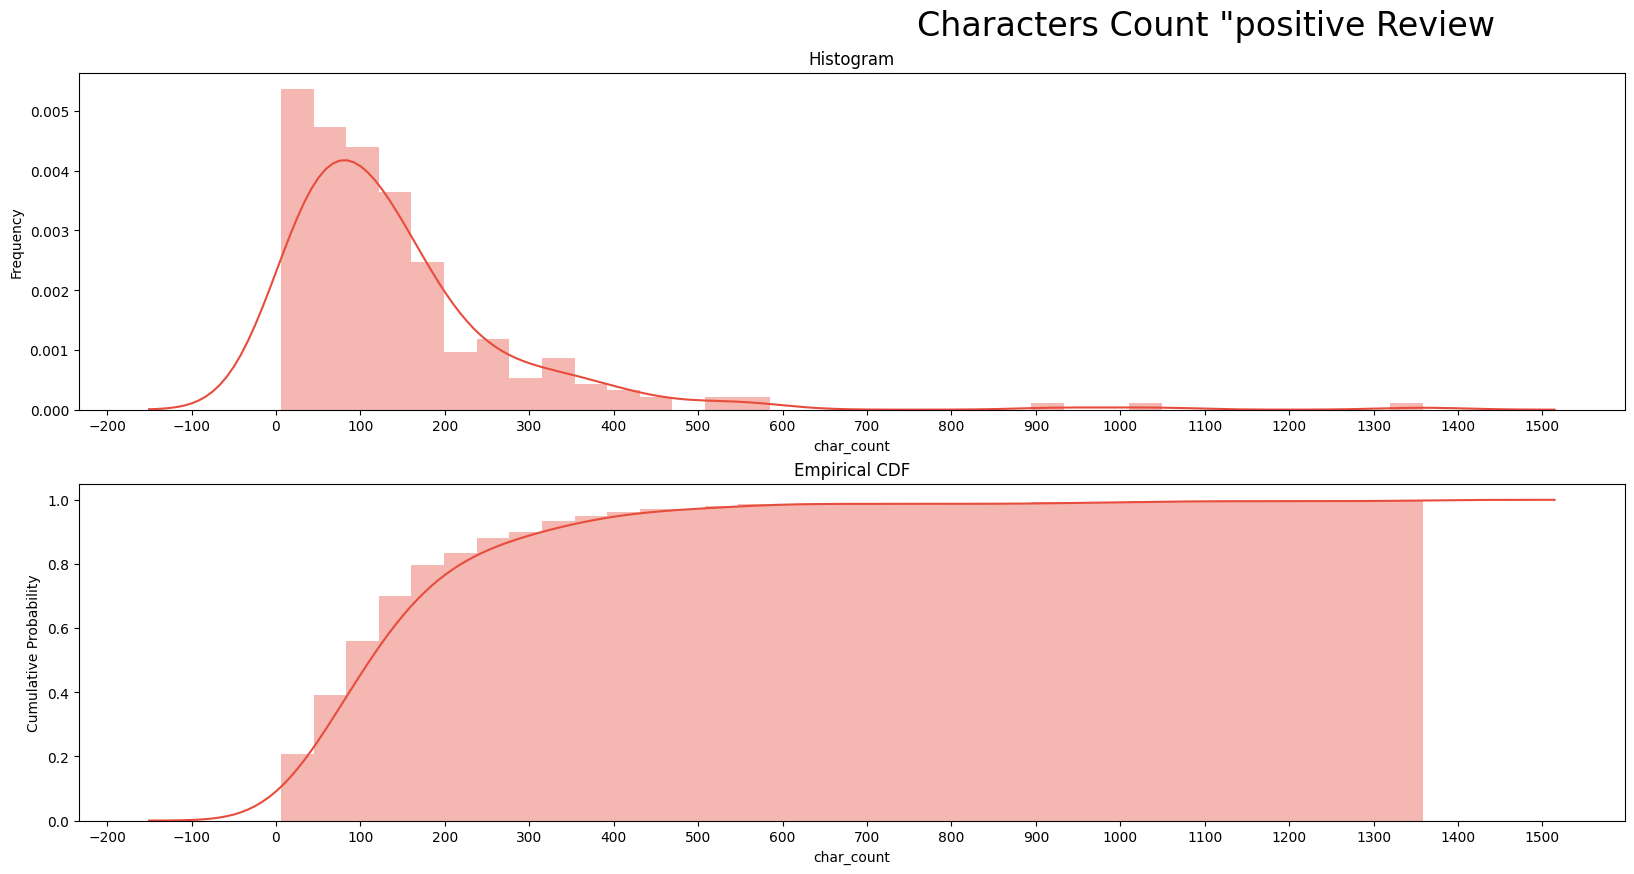

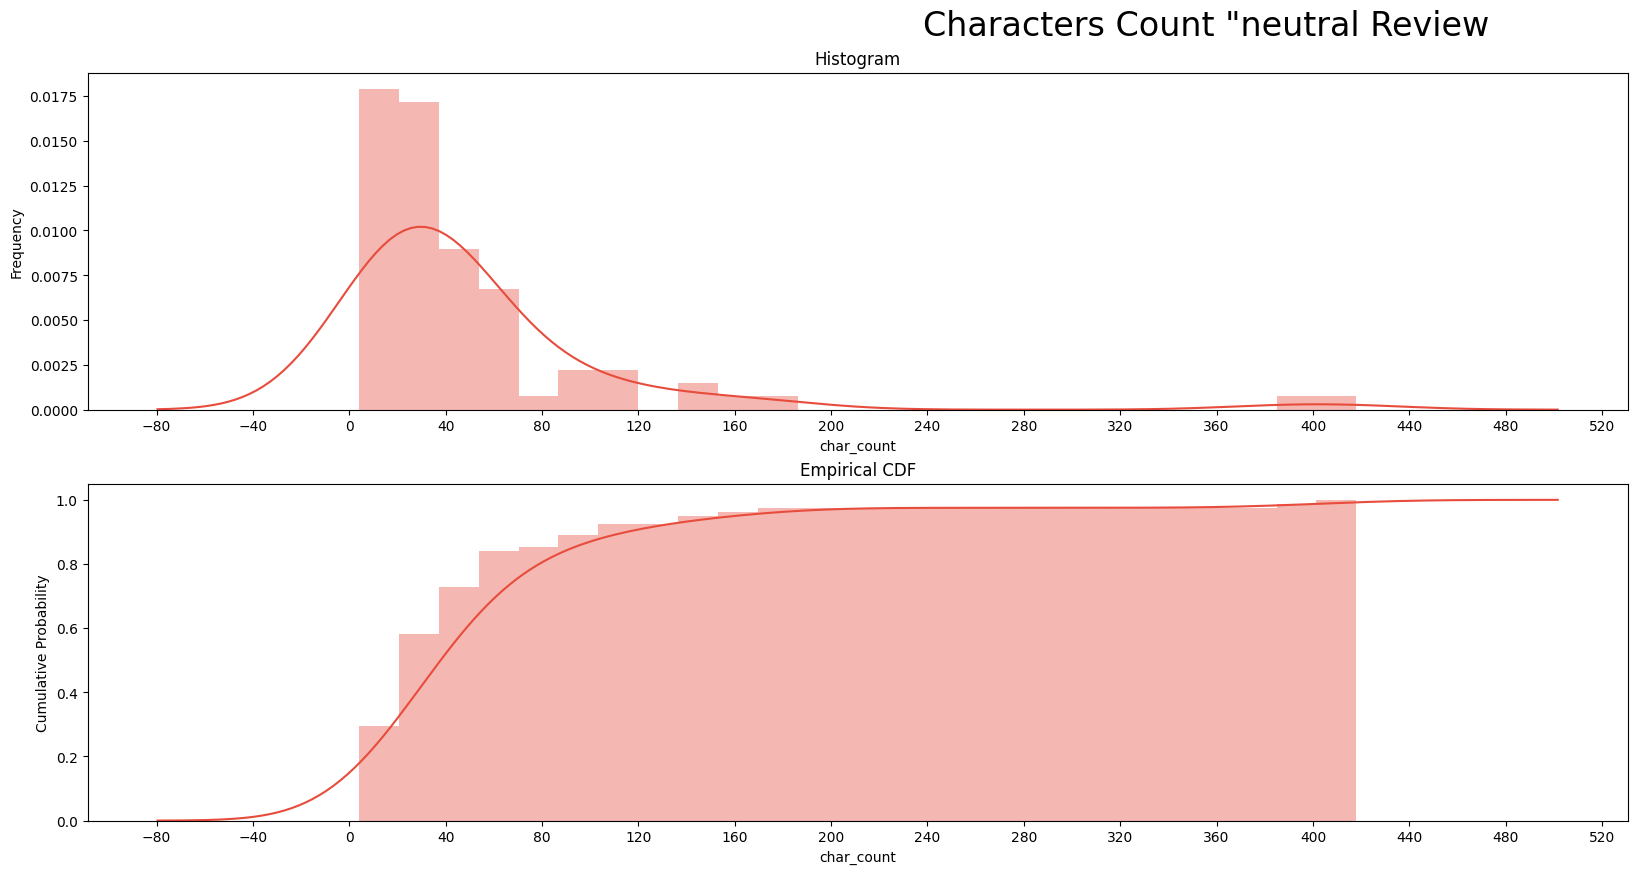

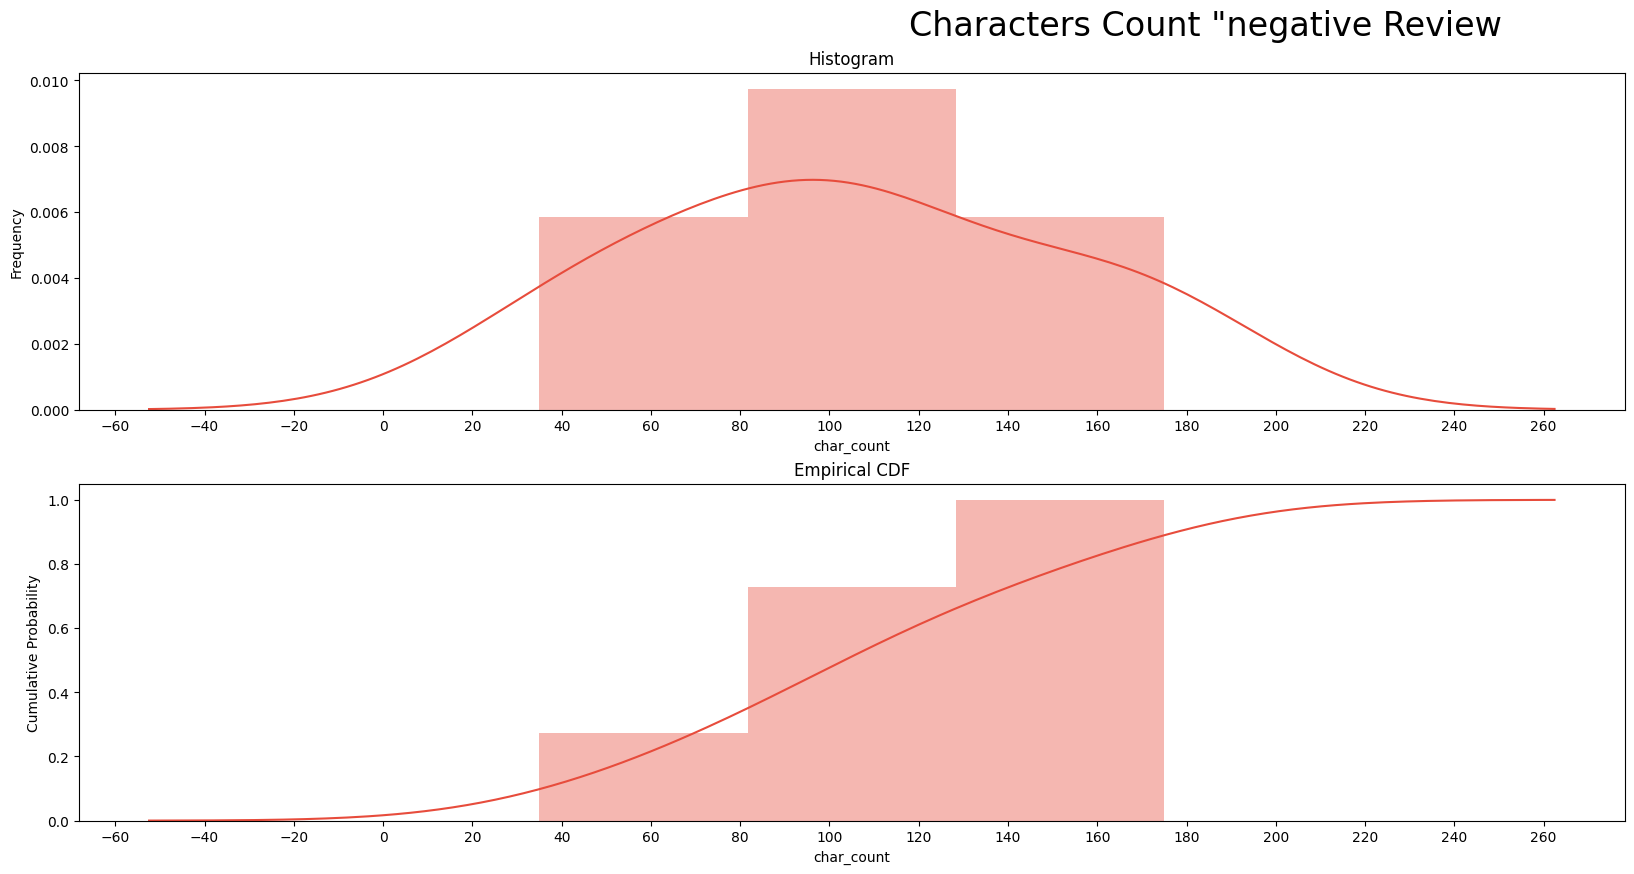

In [144]:
plot_dist3(df[df['label'] == 0], 'char_count',
           'Characters Count "positive Review')
plot_dist3(df[df['label'] == 1], 'char_count',
           'Characters Count "neutral Review')
plot_dist3(df[df['label'] == 2], 'char_count',
           'Characters Count "negative Review')

In [145]:
def plot_word_number_histogram(textno, textye, textz):

    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(18, 12), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    sns.distplot(textz.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')


    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('positive')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('netrual')
    axes[2].set_xlabel('Word Count')
    axes[2].set_title('negative')

    fig.suptitle('Words Per Review', fontsize=24, va='baseline')

    fig.tight_layout()

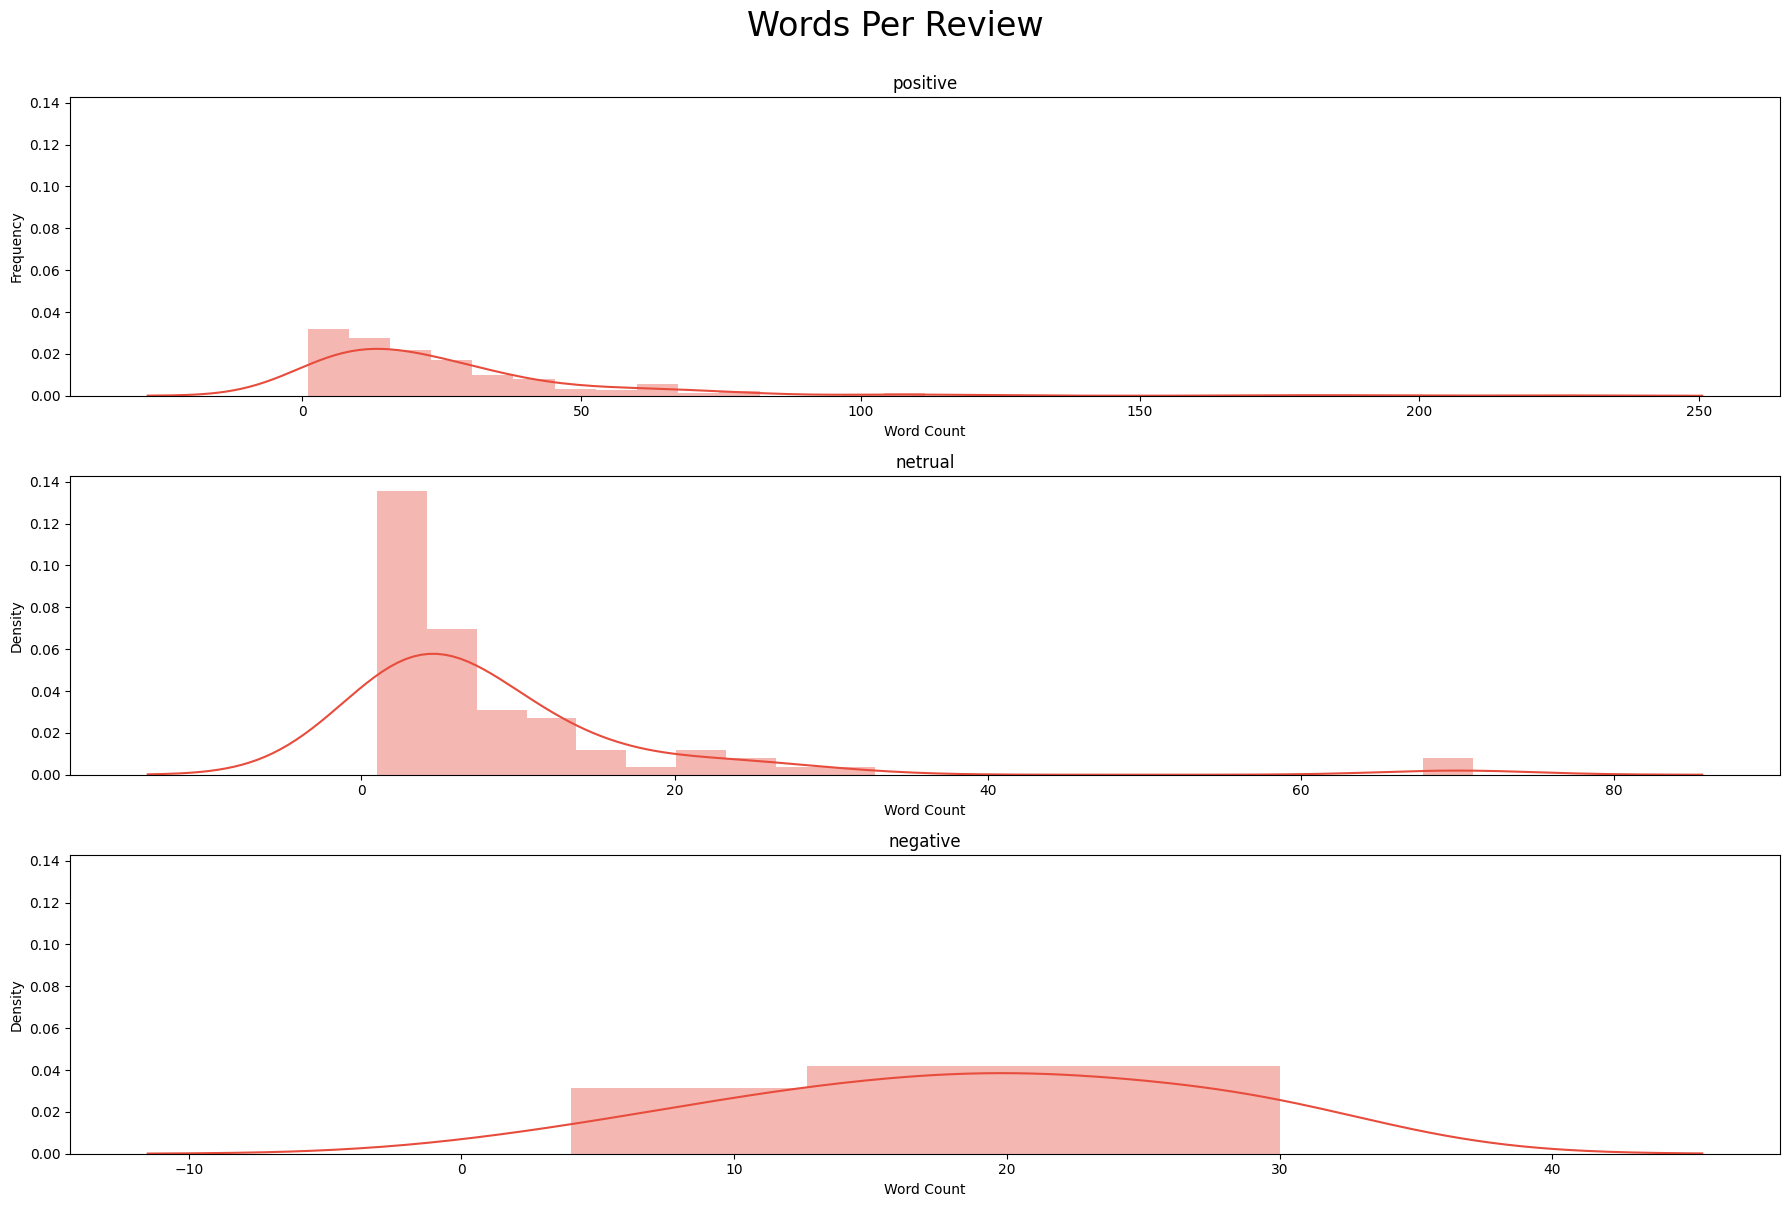

In [146]:
plot_word_number_histogram(df[df['label'] == 0]['Text_Clean'],
                           df[df['label'] == 1]['Text_Clean'],
                           df[df['label'] == 2]['Text_Clean'],
                          )

In [147]:
texts = df['tokenized_review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

In [148]:
fig = make_subplots(rows=1, cols=3)
title_ = ["positive", "neutral", "negative"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

In [149]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [150]:

fig = make_subplots(rows=1, cols=3)

title_ = ["positive", "neutral", "negative"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 1)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)


fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common unigram per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
fig.show()

In [151]:
fig = make_subplots(rows=1, cols=3)

title_ = ["positive", "neutral", "negative"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)


fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common bigram per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
fig.show()

In [152]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [153]:

# Load the data
df = pd.read_csv('/content/sentiment_beto_withlabels.csv')

# Preprocess the text data
df["Text_Clean"] = df["Text"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))
df["label"] = df["AP"].apply(lambda x: label_encode(x))

In [154]:
# Tokenizing the text data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [155]:
# Function to encode the texts using BERT tokenizer
def encode_texts(texts, max_length=128):
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

In [156]:
# Encoding the texts
encoded_texts = encode_texts(df['Text_Clean'].tolist())
input_ids = encoded_texts['input_ids']
attention_masks = encoded_texts['attention_mask']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [157]:
# Converting the labels to torch tensors
labels = torch.tensor(df['label'].values)

In [158]:
# Splitting the data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.1, random_state=2020)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.1, random_state=2020)

In [159]:
# Creating data loaders
batch_size = 32

In [160]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [161]:

# Loading pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,  # Adjust based on the number of sentiment classes
    output_attentions=False,
    output_hidden_states=False
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [162]:
# Defining the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

In [164]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [166]:
!pip show accelerate

Name: accelerate
Version: 0.30.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [167]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [168]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [169]:
# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Text_Clean'], df['label'], test_size=0.1, random_state=42)


In [170]:
# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 4


In [171]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = SentimentDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, MAX_LEN)
val_dataset = SentimentDataset(val_texts.tolist(), val_labels.tolist(), tokenizer, MAX_LEN)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [172]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import numpy as np

In [174]:


class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Text_Clean'], df['label'], test_size=0.1, random_state=42)

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 4

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = SentimentDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, MAX_LEN)
val_dataset = SentimentDataset(val_texts.tolist(), val_labels.tolist(), tokenizer, MAX_LEN)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [176]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [177]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# Scheduler
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def train_epoch(model, dataloader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, dataloader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            loss = loss_fn(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device, scheduler, len(train_dataset))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_dataloader, loss_fn, device, len(val_dataset))
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()


Epoch 1/4
----------
Train loss 0.7281236774043033 accuracy 0.6989966555183946
Val   loss 0.43524911999702454 accuracy 0.7941176470588235

Epoch 2/4
----------
Train loss 0.5450816758369145 accuracy 0.8327759197324415
Val   loss 0.3565277208884557 accuracy 0.8529411764705882

Epoch 3/4
----------
Train loss 0.35600114103994873 accuracy 0.903010033444816
Val   loss 0.38727620740731555 accuracy 0.8529411764705882

Epoch 4/4
----------
Train loss 0.35604567708153473 accuracy 0.9063545150501672
Val   loss 0.6606890757878622 accuracy 0.8235294117647058



In [180]:
def get_predictions(model, dataloader, device):
    model = model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds)
            true_labels.extend(labels)

    predictions = torch.stack(predictions).cpu()
    true_labels = torch.stack(true_labels).cpu()
    return predictions, true_labels

# Get predictions on validation set
val_preds, val_labels = get_predictions(model, val_dataloader, device)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Validation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=['POS',  'NEG']))

print("Validation Confusion Matrix:")
print(confusion_matrix(val_labels, val_preds))

print("Validation Accuracy Score:")
print(accuracy_score(val_labels, val_preds))


Validation Classification Report:
              precision    recall  f1-score   support

         POS       0.83      0.96      0.89        26
         NEG       0.75      0.38      0.50         8

    accuracy                           0.82        34
   macro avg       0.79      0.67      0.70        34
weighted avg       0.81      0.82      0.80        34

Validation Confusion Matrix:
[[25  1]
 [ 5  3]]
Validation Accuracy Score:
0.8235294117647058


In [182]:
def predict_sentiment(text, tokenizer, model, device, max_len=128):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    model = model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

    return preds.item()

# Predict sentiment for a new text
new_text = "This is a fantastic product!"
sentiment = predict_sentiment(new_text, tokenizer, model, device)

sentiment_mapping = {0: 'POS', 1: 'NEG'}
print(f"Sentiment: {sentiment_mapping[sentiment]}")


Sentiment: POS


In [183]:
# Example validation predictions
val_texts_sample = val_texts[:5].tolist()
val_labels_sample = val_labels[:5].tolist()

print("Sample Validation Predictions:")
for i, text in enumerate(val_texts_sample):
    pred = predict_sentiment(text, tokenizer, model, device)
    true = val_labels_sample[i]
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment_mapping[pred]}")
    print(f"True Sentiment: {sentiment_mapping[true]}")
    print("----")


Sample Validation Predictions:
Text: que admirables 2 seres  humanos extraordinarios y salvadore os humildes  inteligentes  brillantes  que orgullo ser salvadore a tuve el honor de saludar al astronauta frank rubio est  semana por all  me lo encontr   saludos para los 2  bendiciones
Predicted Sentiment: POS
True Sentiment: POS
----
Text: el mejor presidente que existe     necesitamos un presidente como usted aqu  en per    ya que  cada vez se hunde este pa s   por que  la corrupci n en imparable
Predicted Sentiment: POS
True Sentiment: POS
----
Text: sara cespedes muchas gracias por esas hermosas palabras saludos hasta australia  que dios bendiga asu pa s
Predicted Sentiment: POS
True Sentiment: NEG
----
Text: presidente un gusto daludarlo  y as  apreciable familia  muchas bendiciones
Predicted Sentiment: POS
True Sentiment: POS
----
Text: jorge olivares claro que si
Predicted Sentiment: NEG
True Sentiment: NEG
----


In [185]:
model.save_pretrained('/content/sentiment_analysis')

In [186]:
import os

# Define the directory to save the model
model_save_path = './saved_model'

# Create the directory if it doesn't exist
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(model_save_path)


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [187]:
from google.colab import files
import shutil

# Zip the model directory
shutil.make_archive(model_save_path, 'zip', model_save_path)

# Download the zip file
files.download(model_save_path + '.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>